In [1]:
import os

os.makedirs("/kaggle/working/dl", exist_ok = True)

for fname in [
    "main.py",
    "VinaFood.py",
    "pretrained.py"
]:
  open(f"/kaggle/working/dl/{fname}", "w").close()

## Fine-tune Pretrained Resnet50

In [2]:
%%writefile /kaggle/working/dl/VinaFood.py
import torch
from torch.utils.data import Dataset
from pathlib import Path # xử lý đường dẫn
from PIL import Image # đọc ảnh
import os

def collate_fn(samples: list[dict]) -> torch.Tensor:
  images = [sample["image"] for sample in samples]
  labels = [sample["label"] for sample in samples]

  images = torch.cat(images, dim = 0) # Ghép các tensor [1, 3, H, W] lại thành [bs, 3, H, W]
  labels = torch.tensor(labels) # Chuyển list các label (số) [0, 1, 2, 0] thành tensor [bs]

  return {
      "image": images,
      "label": labels
  }

class VinaFood(Dataset):
  def __init__(self, image_path: str, transform = None):
    super().__init__()

    self.root_dir = Path(image_path)
    self.transform = transform

    # 1. Lấy danh sách tên thư mục con
    # Sắp xếp thứ tự
    self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])

    # 2. Tạo map từ labels sang số
    self.class_to_idx = {
        cls_name: i for i, cls_name in enumerate(self.classes)
    }

    # 3. Quét toàn bộ thư mục để lấy đường dẫn ảnh và nhãn tương ứng
    self.samples = []

    for class_name in self.classes:
      class_idx = self.class_to_idx[class_name] # lấy số
      class_dir = self.root_dir / class_name

      # Lặp qua các file trong thư mục clas đó
      for img_path in class_dir.iterdir():
        self.samples.append((img_path,class_idx))

  def __len__(self) -> int:
    return len(self.samples)

  def __getitem__(self, idx) -> dict:
    # Lấy đường dẫn và nhãn qua index
    img_path, label = self.samples[idx]

    # Đọc ảnh
    image = Image.open(img_path).convert("RGB")

    # Áp dụng transform nếu có
    if self.transform:
      image = self.transform(image)

    if isinstance(image, torch.Tensor):
      image = image.unsqueeze(0)

    return {
        "image": image,
        "label": label
    }

Overwriting /kaggle/working/dl/VinaFood.py


In [3]:
%%writefile /kaggle/working/dl/pretrained.py
import torch
from torch import nn
from transformers import ResNetForImageClassification

class PretrainedResnet(nn.Module):
    def __init__(self):
        super().__init__()

        basemodel = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

        self.resnet = basemodel.resnet
        self.classifier = nn.Linear(in_features=2048, out_features=21, bias=True)

    def forward(self, images: torch.Tensor):
        features = self.resnet(images).pooler_output
        features = features.squeeze(-1).squeeze(-1)
        logits = self.classifier(features)

        return logits

Overwriting /kaggle/working/dl/pretrained.py


In [ ]:
%%writefile /kaggle/working/dl/main.py
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import numpy as np
import os
import torchvision.transforms as transforms
from VinaFood import collate_fn as vinafood_collate_fn, VinaFood
from pretrained import PretrainedResnet 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_DIR = "/kaggle/working/"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def evaluate(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module) -> dict:
    model.eval()
    predicts = []
    labels_list = []
    losses = []

    with torch.no_grad():
        for item in dataloader:
            image = item["image"].to(device)
            label = item["label"].to(device)
            output = model(image)

            loss = loss_fn(output, label) 
            losses.append(loss.item())
            output = output.argmax(dim=-1)

            predicts.extend(output.cpu().numpy())
            labels_list.extend(label.cpu().numpy())

    return {
        "loss": np.array(losses).mean(),
        "accuracy": accuracy_score(labels_list, predicts),
        "precision": precision_score(labels_list, predicts, average="macro", zero_division=0),
        "recall": recall_score(labels_list, predicts, average="macro", zero_division=0),
        "f1": f1_score(labels_list, predicts, average="macro", zero_division=0)
    }

def print_digit_metrics(predicts, labels_list, num_classes):
    print(f"\nBảng kết quả từng lớp (total: {num_classes} lớp):")
    print("Class | Precision | Recall | F1-Score")
    print("-" * 45)

    precision = precision_score(labels_list, predicts, average=None, zero_division=0)
    recall = recall_score(labels_list, predicts, average=None, zero_division=0)
    f1 = f1_score(labels_list, predicts, average=None, zero_division=0)

    for i in range(num_classes): 
        prec = precision[i] if i < len(precision) else 0.0
        rec = recall[i] if i < len(recall) else 0.0
        f1_s = f1[i] if i < len(f1) else 0.0
        print(f"{i:5d} | {prec:.4f}     | {rec:.4f} | {f1_s:.4f}")

def save_checkpoint(epoch, model, optimizer, best_score, best_score_name, filename):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, filename)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_score': best_score,
        'best_score_name': best_score_name,
    }, checkpoint_path)
    print(f"-> Checkpoint được lưu ở {checkpoint_path}")

def load_checkpoint(model, optimizer, filename):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, filename)
    start_epoch = 0
    best_score = 0
    best_score_name = "accuracy" 

    if os.path.exists(checkpoint_path):
        print(f"-> Tải checkpoint từ {checkpoint_path}...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_score = checkpoint.get('best_score', 0)
        best_score_name = checkpoint.get('best_score_name', "accuracy")
        print(f"Đã tải được checkpoint. Tiếp tục train từ epoch: {start_epoch}. Best score hiện tại: {best_score:.4f}")
    else:
        print(f"Không tìm thấy checkpoint tại {checkpoint_path}. Bắt đầu train lại...")

    return start_epoch, best_score, best_score_name

if __name__ == "__main__":
    
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]

    # Transform cho training (có data augmentation)
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)), # Cắt ngẫu nhiên
        transforms.RandomHorizontalFlip(), # Lật ngang ngẫu nhiên
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])

    # Transform cho test/validation (không augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])
    
    model_name = "PretrainedResnet"
    model_class = PretrainedResnet 
    
    train_dataset = VinaFood(
        image_path="/kaggle/input/vinafood21/VinaFood21/train", 
        transform=train_transform
    )
    test_dataset = VinaFood(
        image_path="/kaggle/input/vinafood21/VinaFood21/test",
        transform=val_transform 
    )
    collate_fn_to_use = vinafood_collate_fn
    
    num_labels = 21 
    
    checkpoint_filename = "PretrainedResnet_finetuned.pth" 


    print(f"Bắt đầu huấn luyện mô hình: {model_name}")

    # Tạo dataloaders
    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=collate_fn_to_use
    )
    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=collate_fn_to_use
    )

    # Khởi tạo mô hình, loss, optimizer
    model = model_class().to(device) 
    loss_fn = nn.CrossEntropyLoss().to(device)
    # Fine-tuning nên dùng LR nhỏ
    optimizer = optim.Adam(model.parameters(), lr=1e-4) 

    # Tải checkpoint (nếu có)
    start_epoch, best_score, best_score_name = load_checkpoint(model, optimizer, checkpoint_filename)

    history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
    }
    
    # Training loop
    EPOCHS = 10
    for epoch in range(start_epoch, EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS} - Model: {model_name}:")
        train_preds = []
        train_labels = []
        losses = []
        model.train()
        for item in train_dataloader:
            image = item["image"].to(device)
            label = item["label"].to(device)

            output = model(image)
            loss = loss_fn(output, label)

            train_preds.extend(output.argmax(dim=-1).cpu().numpy())
            train_labels.extend(label.cpu().numpy())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        avg_loss = np.array(losses).mean()
        avg_train_acc = accuracy_score(train_labels, train_preds) # Tính train acc
        history['loss'].append(avg_loss)
        history['accuracy'].append(avg_train_acc)

        print(f"Loss: {avg_loss:.4f} - Accuracy: {avg_train_acc:.4f}")

        scores = evaluate(test_dataloader, model, loss_fn) 

        history['val_loss'].append(scores['loss'])
        history['val_accuracy'].append(scores['accuracy'])

        print(f"  - val_loss: {scores['loss']:.4f}")
        print(f"  - val_accuracy: {scores['accuracy']:.4f}")
        
        current_score = scores.get(best_score_name, 0)
        if current_score > best_score:
            best_score = current_score
            save_checkpoint(epoch, model, optimizer, best_score, best_score_name, checkpoint_filename)
            print(f"-> Đã lưu mô hình tốt nhất {best_score_name}: {best_score:.4f}")


    # Final evaluation
    print("\n" + "="*50)
    print("ĐÁNH GIÁ CUỐI CÙNG")
    print("="*50)

    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_dataloader:
            images = batch['image'].to(device)
            labels = batch['label']
            outputs = model(images)
            predicted = outputs.argmax(dim=-1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    print_digit_metrics(all_preds, all_labels, num_labels)

    all_possible_labels = list(range(num_labels))
    cm = confusion_matrix(all_labels, all_preds, labels=all_possible_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix của mô hình {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("\nĐang vẽ biểu đồ Loss và Accuracy...")
    plt.figure(figsize=(12,4))
    
    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(history['loss'], label='train loss')
    plt.plot(history['val_loss'], label='val loss')
    plt.legend()
    plt.title('Loss')

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(history['accuracy'], label='train acc')
    plt.plot(history['val_accuracy'], label='val acc')
    plt.legend()
    plt.title('Accuracy')
    
    plt.show()

Overwriting /kaggle/working/dl/main.py


2025-10-30 14:21:35.613029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761834095.859238      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761834095.937672      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Bắt đầu huấn luyện mô hình: PretrainedResnet


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Không tìm thấy checkpoint tại /kaggle/working/PretrainedResnet_finetuned.pth. Bắt đầu train lại...

Epoch 1/10 - Model: PretrainedResnet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 2.6181 - Accuracy: 0.2359
  - val_loss: 1.9919
  - val_accuracy: 0.4868
-> Checkpoint được lưu ở /kaggle/working/PretrainedResnet_finetuned.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.4868

Epoch 2/10 - Model: PretrainedResnet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 1.3238 - Accuracy: 0.6582
  - val_loss: 0.9724
  - val_accuracy: 0.7216
-> Checkpoint được lưu ở /kaggle/working/PretrainedResnet_finetuned.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.7216

Epoch 3/10 - Model: PretrainedResnet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 0.7322 - Accuracy: 0.7849
  - val_loss: 0.7604
  - val_accuracy: 0.7701
-> Checkpoint được lưu ở /kaggle/working/PretrainedResnet_finetuned.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.7701

Epoch 4/10 - Model: PretrainedResnet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 0.5174 - Accuracy: 0.8462
  - val_loss: 0.6405
  - val_accuracy: 0.8010
-> Checkpoint được lưu ở /kaggle/working/PretrainedResnet_finetuned.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.8010

Epoch 5/10 - Model: PretrainedResnet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 0.4151 - Accuracy: 0.8736
  - val_loss: 0.5776
  - val_accuracy: 0.8233
-> Checkpoint được lưu ở /kaggle/working/PretrainedResnet_finetuned.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.8233

Epoch 6/10 - Model: PretrainedResnet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 0.3298 - Accuracy: 0.9008
  - val_loss: 0.5327
  - val_accuracy: 0.8342
-> Checkpoint được lưu ở /kaggle/working/PretrainedResnet_finetuned.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.8342

Epoch 7/10 - Model: PretrainedResnet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 0.2683 - Accuracy: 0.9188
  - val_loss: 0.5269
  - val_accuracy: 0.8355
-> Checkpoint được lưu ở /kaggle/working/PretrainedResnet_finetuned.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.8355

Epoch 8/10 - Model: PretrainedResnet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 0.2158 - Accuracy: 0.9372
  - val_loss: 0.5078
  - val_accuracy: 0.8454
-> Checkpoint được lưu ở /kaggle/working/PretrainedResnet_finetuned.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.8454

Epoch 9/10 - Model: PretrainedResnet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 0.1825 - Accuracy: 0.9467
  - val_loss: 0.5170
  - val_accuracy: 0.8441

Epoch 10/10 - Model: PretrainedResnet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 0.1563 - Accuracy: 0.9541
  - val_loss: 0.4880
  - val_accuracy: 0.8508
-> Checkpoint được lưu ở /kaggle/working/PretrainedResnet_finetuned.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.8508

ĐÁNH GIÁ CUỐI CÙNG

Bảng kết quả từng lớp (total: 21 lớp):
Class | Precision | Recall | F1-Score
---------------------------------------------
    0 | 0.8050     | 0.9419 | 0.8681
    1 | 0.8003     | 0.9176 | 0.8550
    2 | 0.9201     | 0.9170 | 0.9185
    3 | 0.9727     | 0.7830 | 0.8676
    4 | 0.8859     | 0.8544 | 0.8699
    5 | 0.8333     | 0.9091 | 0.8696
    6 | 0.8191     | 0.7518 | 0.7840
    7 | 0.9586     | 0.9720 | 0.9653
    8 | 0.7964     | 0.7870 | 0.7917
    9 | 0.9314     | 0.8886 | 0.9095
   10 | 0.8298     | 0.8478 | 0.8387
   11 | 0.5775     | 0.6316 | 0.6034
   12 | 0.9139     | 0.9517 | 0.9324
   13 | 0.9574     | 0.9091 | 0.9326
   14 | 0.8392     | 0.8280 | 0.8336
   15 | 0.7754     | 0.7621 | 0.7687
   16 | 0.8910     | 0.8688 | 0.8797
   17 | 0.7984     | 0.8583 | 0.8

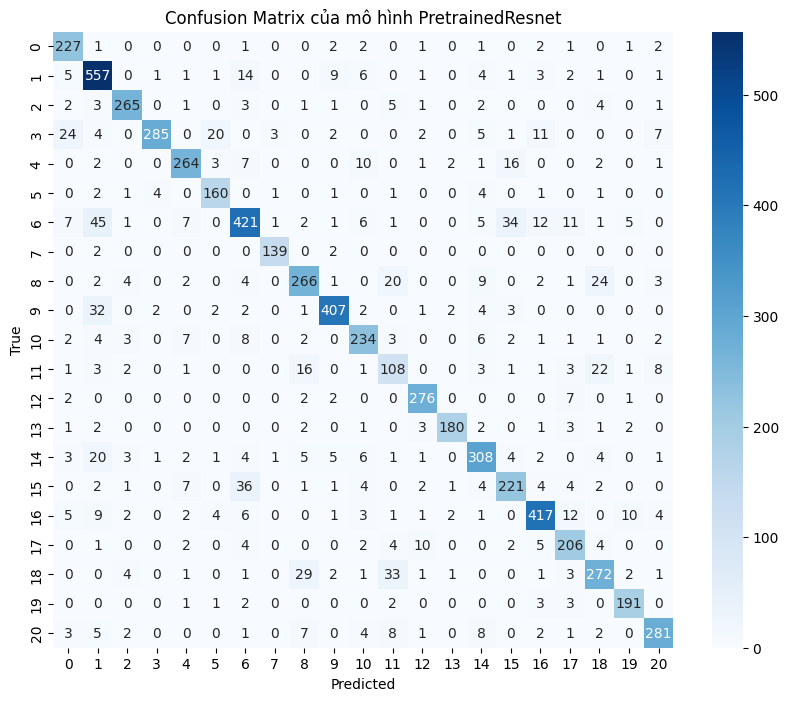


Đang vẽ biểu đồ Loss và Accuracy...


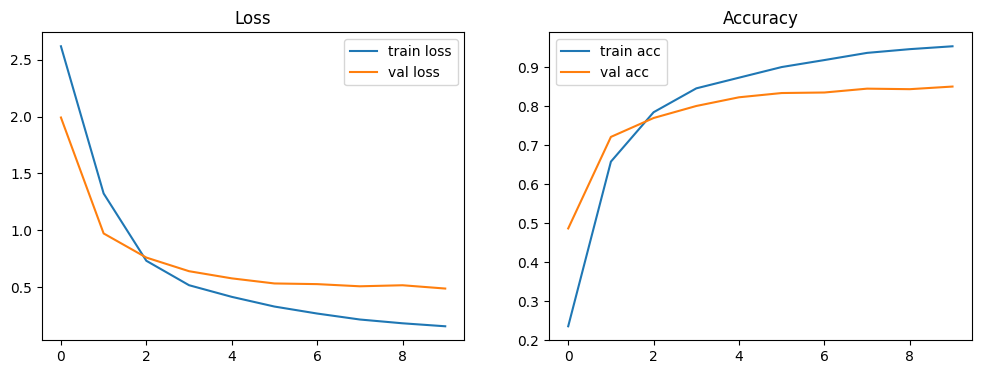

<Figure size 640x480 with 0 Axes>

In [5]:
import sys
sys.path.insert(0, '/kaggle/working/dl')
%run /kaggle/working/dl/main.py